In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from yellowbrick.cluster import KElbowVisualizer

from scipy import stats 
from scipy.spatial.distance import mahalanobis
from scipy.cluster.hierarchy import dendrogram, fcluster

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import Ridge
from sklearn import metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import jarque_bera

from pingouin import multivariate_normality

from sample_size_calculation import *

%load_ext autoreload
%autoreload 2

In [3]:
data_to_cluster = pd.read_csv("Данные/processed/clustering-data-structure-volume.csv")
data_to_cluster.head()

,Код раздела,Название раздела,Всего основных фондов,Здания,Машины и оборудование,Сооружения,Транспортные средства
0,A,"Сельское, лесное хозяйство, охота, рыболовство...",1.265974e+07,0.341619,0.326061,0.125921,0.061751
1,B,Добыча полезных ископаемых,4.200038e+07,0.069519,0.185504,0.700053,0.026976
2,C,Обрабатывающие производства,4.013153e+07,0.216858,0.495025,0.231176,0.029704
3,D,"Обеспечение электрической энергией, газом и па...",2.925099e+07,0.156394,0.341688,0.463022,0.011453
4,E,"Водоснабжение; водоотведение, организация сбор...",5.519033e+06,0.122118,0.114837,0.712306,0.036490


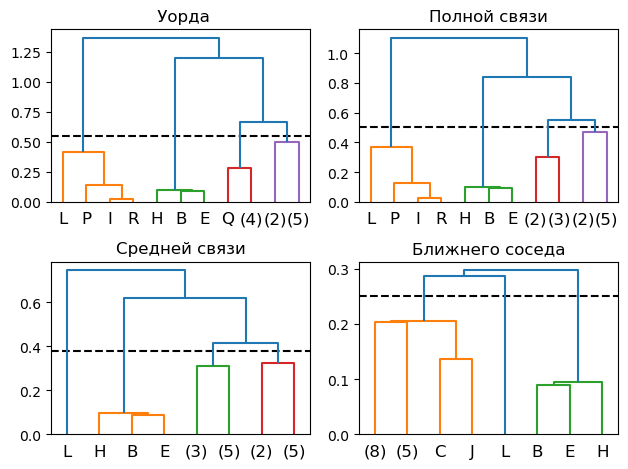

In [4]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

feature_labels_assets = ["Здания", "Машины и оборудование", \
    "Сооружения", "Транспортные средства"]
# feature_labels_assets = ["Здания", "Машины и оборудование", \
#     "Сооружения"]
X = data_to_cluster.loc[:, feature_labels_assets]
# scaler = MinMaxScaler()
# X["Всего основных фондов"] = scaler.fit_transform(X.loc[:, ["Всего основных фондов"]])

linkage_types = ['ward', 'complete', 'average', 'single']
cutoff_thresholds = [0.55, 0.5, 0.38, 0.25]
linkage_colors = dict(zip(linkage_types, cutoff_thresholds))
labels = [' Уорда', 'Полной связи', "Средней связи", "Ближнего соседа"]
linkage_labels = dict(zip(linkage_types, labels))

mpl.rcParams.update(mpl.rcParamsDefault)
hclust = dict()
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for linkage_type, axs_ind in zip(linkage_types, axs_indices):
    model = AgglomerativeClustering(linkage=linkage_type, distance_threshold=0, n_clusters=None)
    clustering = model.fit(X)
    axs[axs_ind].set_title(linkage_labels[linkage_type])
    axs[axs_ind].axhline(y=linkage_colors[linkage_type], linestyle='dashed', color='black')
    linkage_matrix = plot_dendrogram(
        clustering,
        truncate_mode="level",
        p=3,
        ax=axs[axs_ind], 
        labels=data_to_cluster["Код раздела"].to_list(),
        color_threshold = linkage_colors[linkage_type]
        # orientation='right'
        )
    
    hclust[linkage_type] = {
        "clustering": clustering,
        "linkage_matrix": linkage_matrix
    }
fig.tight_layout()
plt.show()


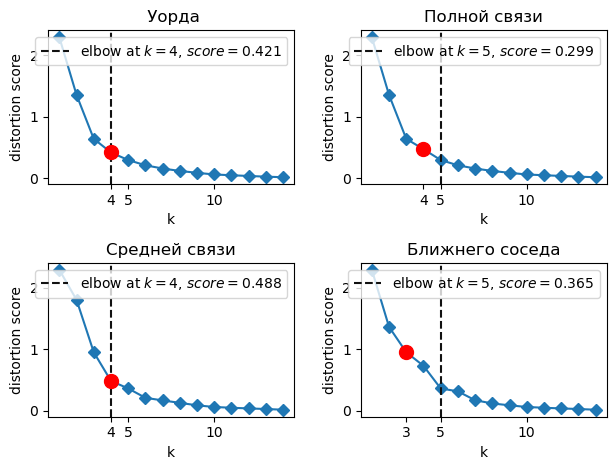

In [5]:
chosen_x = [4., 4., 4., 3.]
chosen_y = [0.421457, 0.475347, 0.487812, 0.953896]
scores = []
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for i, linkage_type, axs_ind in zip(range(4), linkage_types, axs_indices):
    model = AgglomerativeClustering(linkage=linkage_type)
    visualizer = KElbowVisualizer(
        model,
        k=(1,15),
        ax=axs[axs_ind], 
        timings=False,
        title = linkage_labels[linkage_type],
        locate_elbow=True
        )
    visualizer.fit(X)
    visualizer.finalize()
    ticks = axs[axs_ind].get_xticks()
    ticks = np.append(ticks, chosen_x[i])
    axs[axs_ind].set_xticks(ticks)
    axs[axs_ind].plot([chosen_x[i]], [chosen_y[i]], \
        marker='o', ms=10, c='red')
    # if linkage_type == 'single':
    #     axs[axs_ind].axvline(x=linkage_chosen_k[linkage_type], color='red', \
    #         linestyle='dashdot')
    scores.append(visualizer.k_scores_)
fig.tight_layout()
# print()
plt.show()

In [6]:
df = pd.DataFrame(scores)
df = df.transpose().rename(columns=dict(zip(df.columns, labels)))
df = df.rename(index=dict(zip(df.index, range(1,df.shape[0]))))
pd.set_option('display.precision', 2)
# pd.reset_option('display.precision')
df.head()

,Уорда,Полной связи,Средней связи,Ближнего соседа
1,2.29,2.29,2.29,2.29
2,1.36,1.36,1.81,1.37
3,0.64,0.64,0.95,0.95
4,0.42,0.48,0.49,0.73
5,0.30,0.30,0.37,0.37


In [7]:
cutoff_thresholds = cutoff_thresholds
cluster_mapping = data_to_cluster.loc[:, :"Код раздела"]
# cluster_mapping = data_to_cluster
cluser_count = []
for linkage_type, t in zip(linkage_types, cutoff_thresholds):
    enum = fcluster(hclust[linkage_type]["linkage_matrix"], t=t, criterion='distance')
    model = hclust[linkage_type]["clustering"]
    # hclust[linkage_type]["score"] = metrics.silhouette_score(X, enum, metric='euclidean')
    cluster_mapping[linkage_type] = enum
    cluser_count.append(cluster_mapping.nunique()[linkage_type])
# ind = data_to_cluster[data_to_cluster['Код раздела'].isin(['A','B'])].index
# data_to_cluster = data_to_cluster.drop(ind)
# cluster_mapping.head()
# data_to_cluster.head()
# cluser_count

In [8]:
data_clustered = pd.merge(data_to_cluster, cluster_mapping, 'inner', "Код раздела")
data_clustered.to_csv('Данные/processed/clustering-mapping-structure.csv', index=False) 
data_clustered.head()

,Код раздела,Название раздела,Всего основных фондов,Здания,Машины и оборудование,Сооружения,Транспортные средства,ward,complete,average,single
0,A,"Сельское, лесное хозяйство, охота, рыболовство...",1.27e+07,0.34,0.33,0.13,0.06,3,4,2,1
1,B,Добыча полезных ископаемых,4.20e+07,0.07,0.19,0.70,0.03,2,2,1,3
2,C,Обрабатывающие производства,4.01e+07,0.22,0.50,0.23,0.03,4,4,3,1
3,D,"Обеспечение электрической энергией, газом и па...",2.93e+07,0.16,0.34,0.46,0.01,4,3,3,1
4,E,"Водоснабжение; водоотведение, организация сбор...",5.52e+06,0.12,0.11,0.71,0.04,2,2,1,3


In [9]:
data_clustered.loc[:, [*feature_labels_assets, "ward"]].groupby("ward").count()

,Здания,Машины и оборудование,Сооружения,Транспортные средства
ward,,,,
1,4,4,4,4
2,3,3,3,3
3,5,5,5,5
4,7,7,7,7


In [10]:
clu_num = 4
pd.set_option('display.max_colwidth', None)
# data_clustered[data_clustered["ward"] == clu_num].loc[:, ["Название раздела"]]
data_clustered[data_clustered["ward"] == clu_num]

,Код раздела,Название раздела,Всего основных фондов,Здания,Машины и оборудование,Сооружения,Транспортные средства,ward,complete,average,single
2,C,Обрабатывающие производства,4.01e+07,0.22,0.50,0.23,0.03,4,4,3,1
3,D,"Обеспечение электрической энергией, газом и паром; кондиционирование воздуха",2.93e+07,0.16,0.34,0.46,0.01,4,3,3,1
5,F,Строительство,4.60e+06,0.20,0.34,0.23,0.17,4,3,3,1
9,J,Деятельность в области информации и связи,8.94e+06,0.09,0.53,0.23,0.01,4,4,3,1
12,M,"Деятельность профессиональная, научная и техническая",1.04e+07,0.28,0.28,0.34,0.04,4,3,3,1
13,N,Деятельность административная и сопутствующие дополнительные услуги,4.34e+06,0.23,0.22,0.29,0.22,4,3,3,1
14,O,Государственное управление и обеспечение военной безопасности; социальное обеспечение,3.30e+07,0.28,0.13,0.38,0.05,4,3,3,1


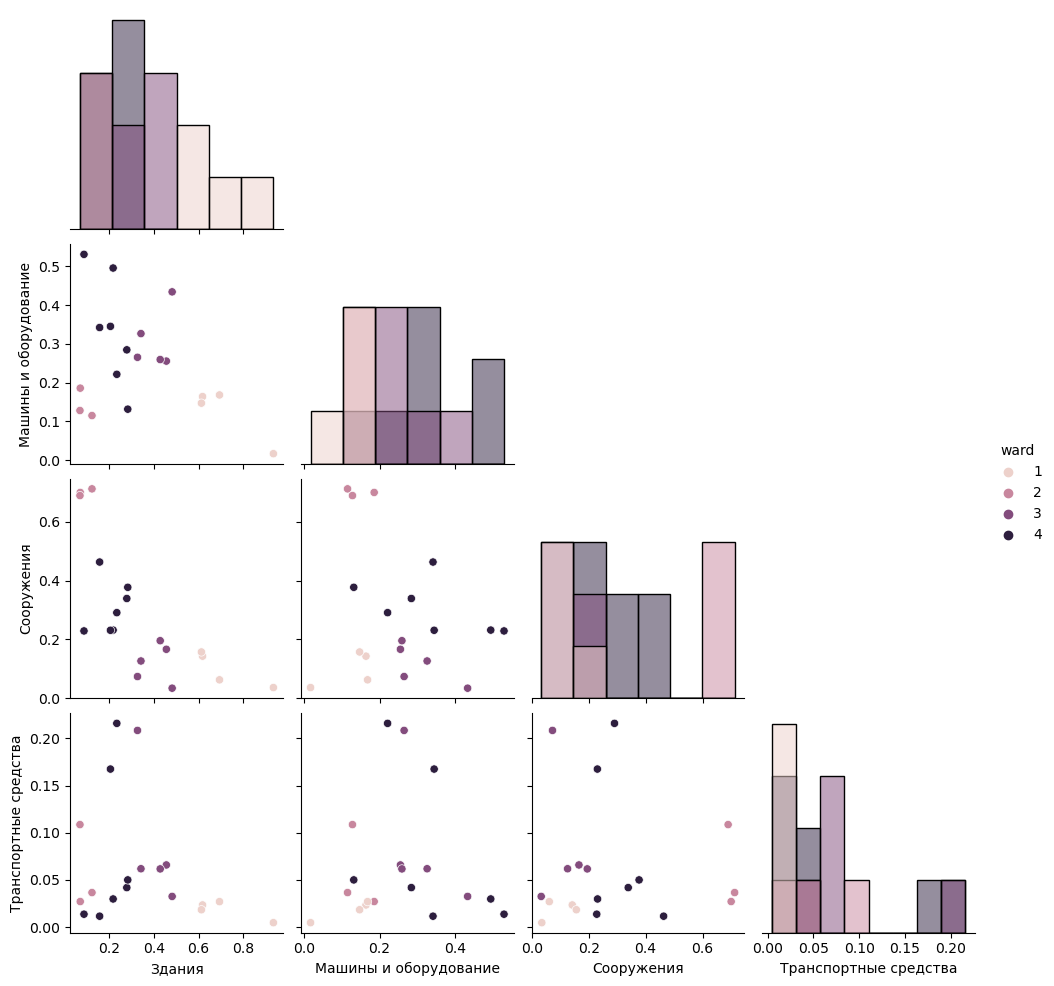

In [11]:
import warnings
warnings.filterwarnings('ignore')
# pd.reset_option('all')
sns.pairplot(data_clustered.loc[:, ["Здания", "Машины и оборудование", \
    "Сооружения", "Транспортные средства", "ward"]],corner=True, hue='ward', diag_kind='hist')
plt.show()

In [12]:
data_for_regr = pd.read_csv('Данные/processed/regression-data-v0.csv')
data_for_regr.head()
feature_labels_douglas = ['ROFA', 'K','L', 't']
# data_exprimental = data_for_regr.join(data_clustered, on='Код раздела', how='inner')
# data_exprimental.loc[:, 'ROFA':'t'].corr()

In [13]:
X = data_for_regr.loc[:, "ROFA":"L"]
std_arr = X.std().to_numpy()
print(std_arr)
err_rate = 0.1
# delta_arr = X.mean().to_numpy() * err_rate
delta_arr = std_arr / 2.5
N = X.shape[0]
print(N)

sample_sizes = [sample_size_repetitive(0.05, delta, N, std=std) \
    for delta, std in zip(delta_arr, std_arr)]
sample_sizes

[4.11275169e-02 3.94103165e+07 1.48824052e+08]
108


[16.27458538851528, 16.274585388515284, 16.27458538851528]

In [14]:
data_for_regr[[*feature_labels_douglas]].corr()

,ROFA,K,L,t
ROFA,1.00,-0.33,0.54,-0.16
K,-0.33,1.00,0.01,0.18
L,0.54,0.01,1.00,0.21
t,-0.16,0.18,0.21,1.00



Linkage: ward, cluster 3, n: 24
                            OLS Regression Results                            
Dep. Variable:                ln_ROFA   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     87.75
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           1.10e-11
Time:                        13:59:03   Log-Likelihood:                 2.9892
No. Observations:                  24   AIC:                             2.022
Df Residuals:                      20   BIC:                             6.734
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -92.02

,cluster_id,obs_count,white_pvalue,D-W,VIF_x1,VIF_x2,VIF_x3,JB,HZ
0,3,24,0.0664,0.3323,1.6002,1.1659,1.7519,0.3318,0.0000
1,2,18,0.1053,1.0075,28.8948,28.8565,1.0253,0.2886,0.0000
2,4,42,0.0009,0.3823,1.1772,1.1957,1.0996,0.2682,0.0000
3,1,24,0.0328,0.5935,1.1123,1.1415,1.0875,0.6764,0.0000


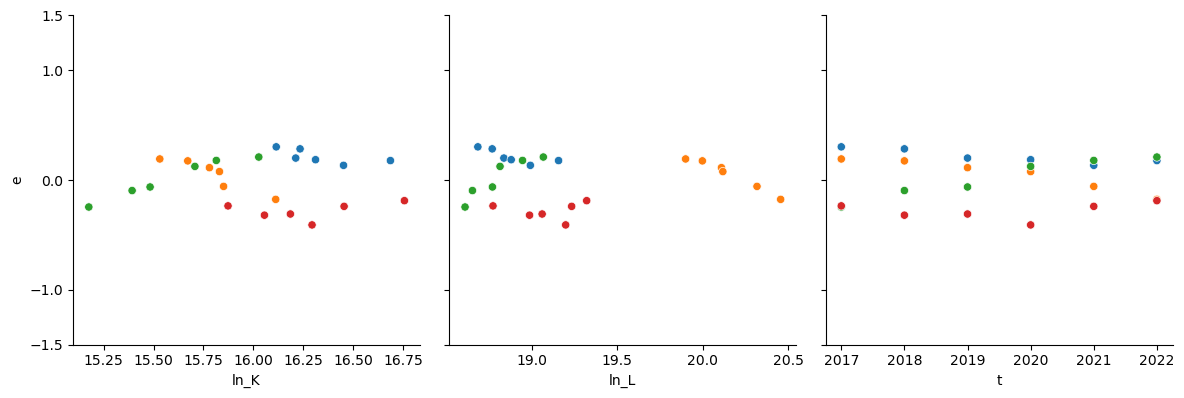

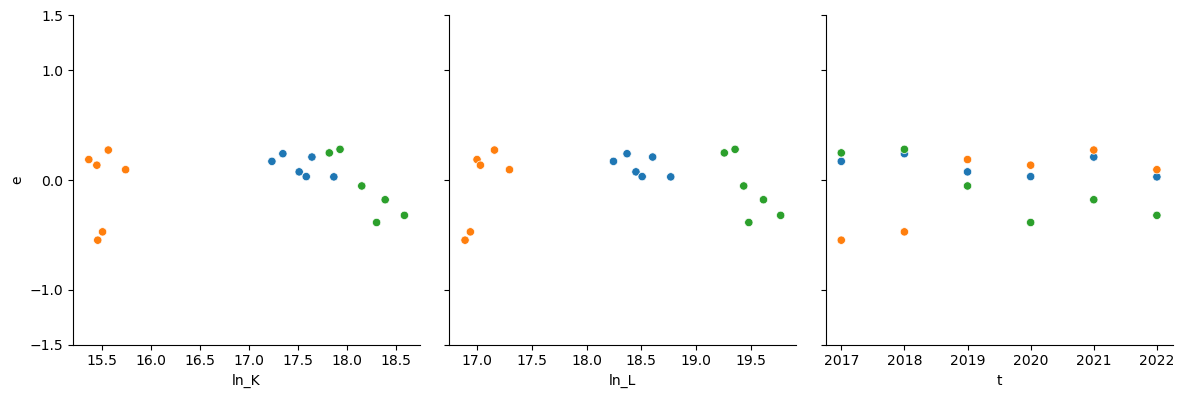

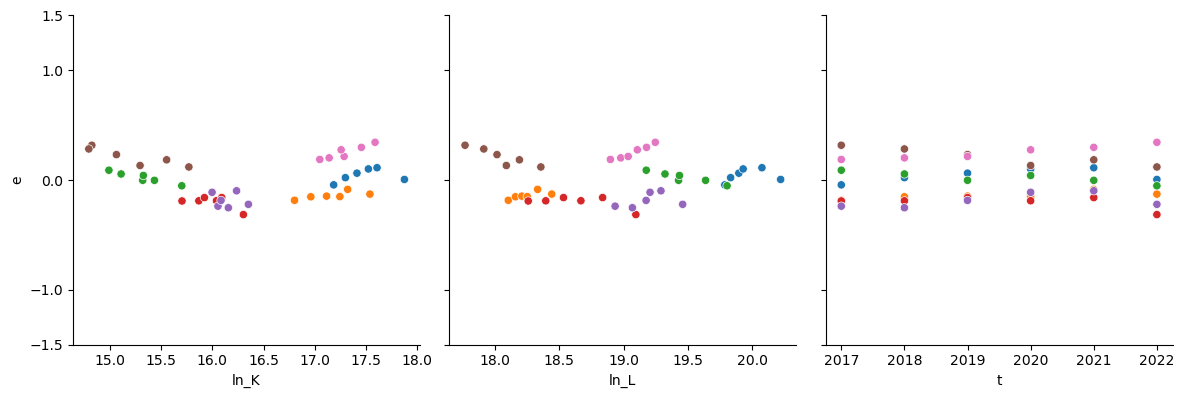

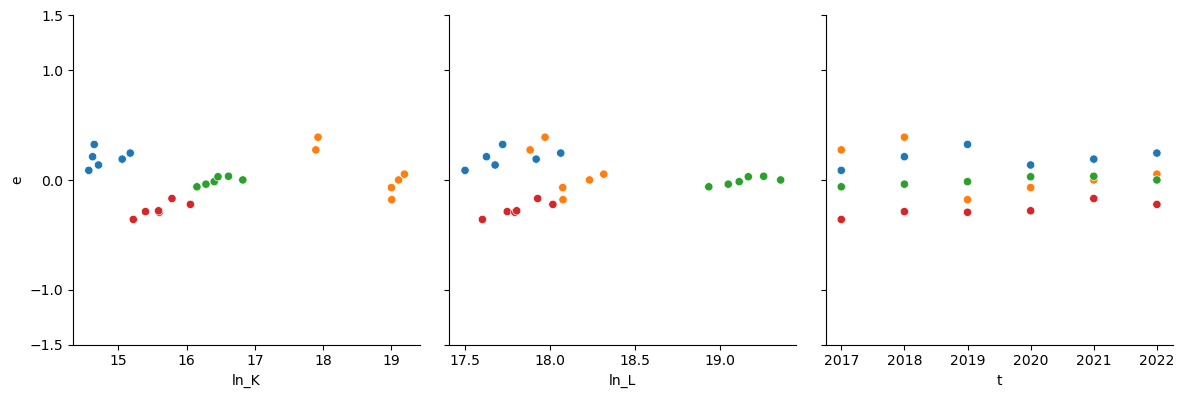

In [15]:
linkage_type = 'ward'
# data_for_regr = data_for_regr[data_for_regr['Код раздела'] != 'G']
data_for_regr_cl = pd.merge(data_for_regr, cluster_mapping, 'inner', "Код раздела")
data_for_regr_cl.loc[:, "ROFA":"L"] = data_for_regr_cl.loc[:, "ROFA":"L"].apply(lambda x: np.log(x))
data_for_regr_cl = data_for_regr_cl.rename(columns={"ROFA": "ln_ROFA", "K": "ln_K", "L": "ln_L"})
SSE_all = []
# print(data_for_regr_cl[['ln_ROFA', 'ln_K', 'ln_L', 't']].corr())
regr_metrics_all = []
for cluster_id in data_for_regr_cl[linkage_type].unique():
    cluster = data_for_regr_cl[data_for_regr_cl[linkage_type] == cluster_id]

    regr_metrics = {}
    X = cluster.loc[:, ["ln_K", "ln_L", "t"]]
    X = sm.add_constant(X)
    Y = cluster.loc[:, ["ln_ROFA"]]
    regression = sm.OLS(Y, X, hasconst=True)
    result_OLS = regression.fit()

    n_lags=X[X.columns[0]].count()
    regr_metrics['cluster_id'] = cluster_id
    regr_metrics['obs_count'] = n_lags

    white_pvalue = sm.stats.diagnostic.het_white(result_OLS.resid, X)[1]
    regr_metrics['white_pvalue'] = white_pvalue

    dw = sm.stats.stattools.durbin_watson(result_OLS.resid)
    regr_metrics['D-W'] = dw

    VIF_array = []
    for exog_idx in range(1, regression.exog.shape[1]):
        VIF = variance_inflation_factor(regression.exog, exog_idx)
        VIF_array.append(round(VIF, 2))
        regr_metrics[f'VIF_x{exog_idx}'] = VIF
    # print('-- VIF:', VIF_array)
    regr_metrics['JB'] = jarque_bera(result_OLS.resid)[1]
    hz, hz_pval, normal = multivariate_normality(regression.exog)
    regr_metrics['HZ'] = hz_pval
    regr_metrics_all.append(regr_metrics)

    print('\nLinkage: {l}, cluster {c}, n: {n}'.format(l=linkage_type, c=cluster_id, n=n_lags))
    print(result_OLS.summary())    
    print('-- White\'s test pvalue: ', white_pvalue)
    print('-- VIF:', VIF_array)

    X_resid = X.iloc[:, 1:]
    X_resid = X_resid.join(pd.DataFrame({"e": result_OLS.resid}))
    X_resid = X_resid.join(data_for_regr_cl['Код раздела'])
    g = sns.PairGrid(X_resid, y_vars=["e"], x_vars=["ln_K", "ln_L", "t"], hue='Код раздела', height=4)
    # g.map(sns.regplot, color=".3", ci=None)
    g.map(sns.scatterplot)
    g.set(ylim=(-1.5, 1.5), yticks=[-1.5, -1, 0, 1, 1.5])

pd.set_option('display.float_format', lambda x: '%.4f' % x)
regr_metrics_all = pd.DataFrame(regr_metrics_all)
# print(regr_metrics_all)
regr_metrics_all
# plt.show()

In [16]:
DW_table = [ 
    ( 24, 0.881, 1.407 ),
    ( 18, 0.708, 1.422 ),
    ( 42, 1.15, 1.456 ),
]
DW_table = pd.DataFrame(DW_table, columns=['n', 'DW_L', 'DW_U'])
DW_table['4-DW_U'] = 4 - DW_table['DW_U']
DW_table['4-DW_L'] = 4 - DW_table['DW_L']
DW_table = DW_table.set_index('n', drop=False)
DW_table.loc[24, 'DW_L']

0.881

In [28]:
# CORRECT AUTOREGRESSION
from help_funcs import ols_ar1, OLSAR1
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

linkage_type = 'ward'
data_for_regr_cl = pd.merge(data_for_regr, cluster_mapping, 'inner', "Код раздела")
data_for_regr_cl.loc[:, "ROFA":"L"] = data_for_regr_cl.loc[:, "ROFA":"L"].apply(lambda x: np.log(x))
data_for_regr_cl = data_for_regr_cl.rename(columns={"ROFA": "ln_ROFA", "K": "ln_K", "L": "ln_L"})
SSE_all = []
# print(data_for_regr_cl[['ln_ROFA', 'ln_K', 'ln_L', 't']].corr())
regr_metrics_all = []
breush_godfrey_all = []
cochrane_log_all = {}
for cluster_id in data_for_regr_cl[linkage_type].unique():
    cluster = data_for_regr_cl[data_for_regr_cl[linkage_type] == cluster_id].sort_values(by='t')

    regr_metrics = {}
    X = cluster.loc[:, ["ln_K", "ln_L", "t"]]
    X = sm.add_constant(X)
    Y = cluster.loc[:, ["ln_ROFA"]]
    regression = sm.OLS(Y, X, hasconst=True)
    result_OLS = regression.fit()

    # RECURSIVE COCHRANE-ORCUTT with P-W fix
    def OLS_AR_n(original_model, max_lag, dw_vals=None, bg_alpha=0.05):
        dw_l, dw_u = dw_vals

        proc_log = {}

        AR_n1 = original_model
        first_lag = 2 + int(original_model.df_model)
        for n_lags in range(0, max_lag+1):
            e_1 = result_OLS.resid[1:].reset_index(drop=True)
            e_0 = result_OLS.resid[:-1].reset_index(drop=True)

            AR_n1_result = AR_n1.fit()
            dw_hat = durbin_watson(AR_n1_result.resid)

            if n_lags > 0:
                bg_result = acorr_breusch_godfrey(original_model.fit(), nlags=n_lags, store=True)
                bg_OLS_result = bg_result[4].resols
                bg_fpvalue = bg_result[3]

                tstat_pvals_all = stats.t.sf(np.abs(bg_OLS_result.tvalues), bg_OLS_result.df_resid)
                tstat_pval_lag = tstat_pvals_all[first_lag + n_lags - 1]
            else:
                tstat_pval_lag = np.nan
                bg_fpvalue = np.nan

            proc_step_log = {
                # 'n lags' : n_lags,
                'DW-stat' : dw_hat,
                'BG t-stat p-value' : tstat_pval_lag,
                'BG F-stat p-value' : bg_fpvalue,
            }
            proc_log[n_lags] = proc_step_log

            aux_reg = sm.OLS(e_0, e_1)

            result_aux = aux_reg.fit()
            rho = result_aux.params[0]
            AR_n0 = ols_ar1(AR_n1, rho)
            AR_n1 = AR_n0
        return(AR_n1, proc_log)

    n=X[X.columns[0]].count()

    max_lag = 5
    dw_vals = (DW_table.loc[n, 'DW_L'], DW_table.loc[n, 'DW_U'])
    OLS_AR, proc_log = OLS_AR_n(regression, max_lag, dw_vals)
    cochrane_log_all[cluster_id] = pd.DataFrame(proc_log)
    result_OLS = OLS_AR.fit()
    # print(result_OLS.summary())

    breush_godfrey = {}
    breush_godfrey['cluster_id'] = cluster_id
    for p in range(1, max_lag+1):
        fpval = sm.stats.diagnostic.acorr_breusch_godfrey(result_OLS, p)[1]
        breush_godfrey[f'p = {p}'] = fpval
    breush_godfrey_all.append(breush_godfrey)

    regr_metrics['cluster_id'] = cluster_id
    regr_metrics['n'] = n

    white_pvalue = sm.stats.diagnostic.het_white(result_OLS.resid, X)[1]
    regr_metrics['white_pvalue'] = white_pvalue

    regr_metrics['R^2'] = result_OLS.rsquared
    regr_metrics['f_pvalue'] = result_OLS.f_pvalue
    
    VIF_array = []
    for exog_idx in range(1, regression.exog.shape[1]):
        VIF = variance_inflation_factor(regression.exog, exog_idx)
        VIF_array.append(round(VIF, 2))
        regr_metrics[f'VIF_x{exog_idx}'] = VIF

    regr_metrics['JB'] = jarque_bera(result_OLS.resid)[1]
    hz, hz_pval, normal = multivariate_normality(regression.exog)

    regr_metrics['HZ'] = hz_pval
    regr_metrics_all.append(regr_metrics)

    dw = sm.stats.stattools.durbin_watson(result_OLS.resid)
    regr_metrics['DW'] = dw

    # print('\nLinkage: {l}, cluster {c}, n: {n}'.format(l=linkage_type, c=cluster_id, n=n))
    # print(result_OLS.summary())    
    # print('-- White\'s test pvalue: ', white_pvalue)
    # print('-- VIF:', VIF_array)

    # X_resid = X.iloc[:, 1:]
    # X_resid = X_resid.join(pd.DataFrame({"e": result_OLS.resid}))
    # X_resid = X_resid.join(data_for_regr_cl['Код раздела'])
    # g = sns.PairGrid(X_resid, y_vars=["e"], x_vars=["ln_K", "ln_L", "t"], hue='Код раздела', height=4)
    # # g.map(sns.regplot, color=".3", ci=None)
    # g.map(sns.scatterplot)
    # g.set(ylim=(-1.5, 1.5), yticks=[-1.5, -1, 0, 1, 1.5])

pd.set_option('display.float_format', lambda x: '%.2f' % x)
breush_godfrey_all = pd.DataFrame(breush_godfrey_all)
regr_metrics_all = pd.DataFrame(regr_metrics_all)
regr_metrics_acorr = pd.DataFrame(regr_metrics_all.loc[:, [ 'cluster_id', 'n', 'DW' ]]) \
    .merge(DW_table.reset_index(drop=True), on='n', how='left')

# cochrane_log_all = pd.DataFrame(cochrane_log_all)
cochrane_log_all = pd.concat(cochrane_log_all, keys=cochrane_log_all.keys())
cochrane_log_all = cochrane_log_all.rename_axis(['cluster_id', 'test'])
cochrane_log_all.sort_values(by='cluster_id').to_clipboard(float_format="%.2f", decimal=',')
# print(regr_metrics_all)

regr_metrics_acorr.sort_values('cluster_id', axis='index'). \
    style.format({
        'DW': '{:.2f}',
        'DW_L': '{:.2f}',
        'DW_U': '{:.2f}',
        '4-DW_U': '{:.2f}',
        '4-DW_L': '{:.2f}',
        }).hide(axis='index')

breush_godfrey_all.sort_values(by='cluster_id', axis='index').style.format('{:.2f}') \
    .format('{:d}', subset=['cluster_id']).hide(axis='index')
cochrane_log_all.sort_values(by='cluster_id')

0    1    2    3    4    5
cluster_id test                                           
1          DW-stat           2.75 2.22 1.84 1.50 1.19 0.93
           BG t-stat p-value  NaN 0.02 0.26 0.05 0.49 0.29
           BG F-stat p-value  NaN 0.03 0.09 0.05 0.12 0.18
2          DW-stat           2.17 2.18 2.20 2.21 2.20 2.17
           BG t-stat p-value  NaN 0.30 0.02 0.49 0.01 0.14
           BG F-stat p-value  NaN 0.60 0.09 0.21 0.02 0.04
3          DW-stat           2.60 2.22 1.94 1.70 1.46 1.24
           BG t-stat p-value  NaN 0.04 0.04 0.17 0.30 0.40
           BG F-stat p-value  NaN 0.08 0.05 0.08 0.15 0.25
4          DW-stat           2.37 2.12 1.92 1.76 1.61 1.43
           BG t-stat p-value  NaN 0.07 0.01 0.22 0.28 0.29
           BG F-stat p-value  NaN 0.14 0.02 0.04 0.07 0.12

In [ ]:
DW_table

,n,DW_L,DW_U,4-DW_U,4-DW_L
n,,,,,
24,24,0.88,1.41,2.59,3.12
18,18,0.71,1.42,2.58,3.29
42,42,1.15,1.46,2.54,2.85


In [ ]:
data_to_cluster = pd.read_csv("Данные/processed/regression-data-v0.csv")
data_clustered_full = pd.merge(data_to_cluster, cluster_mapping, 'inner', "Код раздела")
data_clustered_full = data_clustered_full.drop(columns=['Название раздела'])

In [ ]:
# Check for multivariate normality
group_id = 3
d_clust_g3 = data_clustered_full[data_clustered_full['ward'] == group_id]

print(d_clust_g3.shape)
hz, pval, normal = multivariate_normality(d_clust_g3.loc[:, ['K', 'L', 't']])
print(normal)

(24, 9)
False


In [ ]:
from help_funcs import isMahalanobisOutlier
is_outlier, squared_distances = isMahalanobisOutlier(d_clust_g3.loc[:, ['ROFA', 'K', 'L']]
                                  .to_numpy(), 0.55)
d_clust_g3['is_outlier'] = is_outlier
d_clust_g3['m_dist'] = squared_distances
d_clust_g3.loc[:, [ 'ROFA', 'K', 'L']]

# sns.histplot(d_clust_g3, x='m_dist')
# plt.show()
# sns.boxenplot(d_clust_g3, x='m_dist', k_depth='proportion', outlier_prop=0.5)
# plt.show()
# sns.boxenplot(d_clust_g3, x='m_dist', k_depth='trustworthy', trust_alpha=0.05)

g = sns.PairGrid(data=d_clust_g3.loc[:, ['ROFA', 'K', 'L']], corner=True)
g.map(sns.scatterplot, hue=d_clust_g3['Код раздела'], style=d_clust_g3['is_outlier'], 
      markers={True: 'X', False: 'o'})
g.add_legend()

KeyboardInterrupt: 

2.0973209626492692e+18 2.0673740185932882e+18


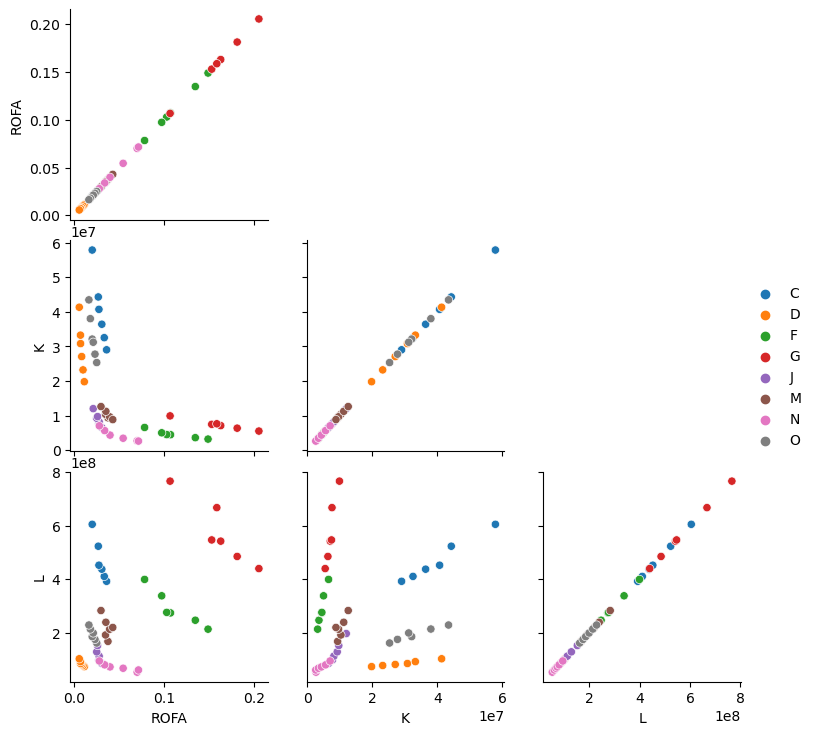

In [ ]:
# SHUFFLE OUTLIERS
# Compute distortion first
from yellowbrick.cluster import distortion_score
data_shuffle1 = data_clustered_full.loc[:, ['Код раздела', *feature_labels_douglas, 'ward']].copy()
distortion1 = distortion_score(data_shuffle1[[*feature_labels_douglas]],
                               data_shuffle1['ward'])
data_shuffle2 = data_shuffle1.copy()
data_shuffle2.loc[data_shuffle2['Код раздела'] == 'G', 'ward'] = 4
distortion2 = distortion_score(data_shuffle2[[*feature_labels_douglas]],
                               data_shuffle2['ward'])
print(distortion1, distortion2)

data_shuffle2_cl4 = data_shuffle2[data_shuffle2['ward'] == 4]
g = sns.PairGrid(data=data_shuffle2_cl4.loc[:, ['ROFA', 'K', 'L']], corner=True)
g.map(sns.scatterplot, hue=data_shuffle2_cl4['Код раздела'],
      # style=data_shuffle2_cl4['is_outlier'], 
      markers={True: 'X', False: 'o'})
g.add_legend()

In [ ]:
# REMOVE OUTLIERS
dc = data_clustered_full.loc[:, [*feature_labels_douglas, 'ward']].copy()
centroids = dc.groupby('ward').mean()
to_move = data_clustered_full[data_clustered_full["Код раздела"] == 'G'].loc[:, \
    [*feature_labels_douglas]]
distances = centroids.apply(lambda c: np.linalg.norm(c - to_move.mean()),
    axis='columns')
distances
# cluster_mapping.loc[cluster_mapping['Код раздела'] == 'G', 'ward'] = 1
# cluster_mapping.loc[cluster_mapping['Код раздела'] == 'G', 'ward'] = 3

ward
1   478279421.38
2   432920491.25
3   302943006.11
4   366254861.97
dtype: float64

In [ ]:
# CORRECT HETEROSCEDASTISITY
from help_funcs import get_whites_regr
import warnings

linkage_type = 'ward'
data_for_regr_cl = data_shuffle2.copy()
data_for_regr_cl.loc[:, "ROFA":"L"] = data_for_regr_cl.loc[:, "ROFA":"L"].apply(lambda x: np.log(x))
data_for_regr_cl = data_for_regr_cl.rename(columns={"ROFA": "ln_ROFA", "K": "ln_K", "L": "ln_L"})
data_for_regr_cl.to_csv("Данные/processed/regression-data-log-ward-v1.csv", index=False)
regr_metrics_all = []

for cluster_id in [1, 4]:
    regr_metrics = {}

    cluster = data_for_regr_cl[data_for_regr_cl[linkage_type] == cluster_id]
    X = cluster.loc[:, ["ln_K", "ln_L", "t"]]
    X = sm.add_constant(X)
    Y = cluster.loc[:, ["ln_ROFA"]]
    regression = sm.OLS(Y, X, hasconst=True)
    result_OLS = regression.fit()


    n_lags=X[X.columns[0]].count()
    # for k in range(1, X.shape[1]):
    #     regr_white_WLS, whites_terms = get_whites_regr(regression, k)
    #     result_white_WLS = regr_white_WLS.fit()
    #     print('\nLinkage: {l}, cluster {c}, n: {n}'.format(l=linkage_type, c=cluster_id, n=n))
    #     print(f'White terms: {whites_terms}')
    #     print(result_white_WLS.summary())
    #     white_pvalue = sm.stats.diagnostic.het_white(result_white_WLS.resid, X)[1]
    #     print('-- White\'s test pvalue: ', white_pvalue)
    
    
    whites_regr, whites_terms = get_whites_regr(regression, full=True)
    result_white_WLS = whites_regr.fit()

    result_OLS = result_white_WLS
    print('\nLinkage: {l}, cluster {c}, n: {n}'.format(l=linkage_type, c=cluster_id, n=n_lags))
    print(result_OLS.summary())    
    regr_metrics['cluster_id'] = cluster_id
    regr_metrics['obs_count'] = n_lags

    white_pvalue = sm.stats.diagnostic.het_white(result_OLS.resid, X)[1]
    print('-- White\'s test pvalue: ', white_pvalue)
    regr_metrics['white_pvalue'] = white_pvalue

    # SSE_i = (result_OLS.resid ** 2).sum()
    # SSE_all.append(SSE_i)
    # print('-- SSE_i: ', round(SSE_i, 2))  

    for exog_idx in range(1, regression.exog.shape[1]):
        VIF = variance_inflation_factor(regression.exog, exog_idx)
        regr_metrics[f'VIF_x{exog_idx}'] = VIF
    # print('-- VIF:', VIF_array)
    regr_metrics['JB'] = jarque_bera(result_OLS.resid)[1]
    hz, hz_pval, normal = multivariate_normality(regression.exog)
    regr_metrics['HZ'] = hz_pval

    regr_metrics_all.append(regr_metrics)

    # X_resid = X_resid.join(data_for_regr_cl['Код раздела'])
    # g = sns.PairGrid(X_resid, y_vars=["e"], x_vars=["ln_K", "ln_L", "t"],
    #                  hue='Код раздела', height=4)
    # # g.map(sns.regplot, color=".3", ci=None)
    # g.map(sns.scatterplot)
    # g.set(ylim=(-1.5, 1.5), yticks=[-1.5, -1, 0, 1, 1.5])

regr_metrics_all = pd.DataFrame(regr_metrics_all)
# print(regr_metrics_all)
regr_metrics_all
# plt.show()


Linkage: ward, cluster 1, n: 24
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            WLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     6189.
Date:                Sun, 17 Mar 2024   Prob (F-statistic):           7.70e-30
Time:                        11:54:43   Log-Likelihood:                 12.877
No. Observations:                  24   AIC:                            -17.75
Df Residuals:                      20   BIC:                            -13.04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        242.52

,cluster_id,obs_count,white_pvalue,VIF_x1,VIF_x2,VIF_x3,JB,HZ
0,1,24,0.03,1.11,1.14,1.09,0.63,0.00
1,4,48,0.00,1.08,1.08,1.10,0.25,0.00


In [ ]:
d_clust_g2 = data_for_regr_cl[data_for_regr_cl['ward'] == 2][
    ['ln_ROFA', 'ln_K', 'ln_L', 't']]
d_clust_g2.corr()
# sns.heatmap(d_clust_g2.corr(), fmt='.2f', annot=True)
# plt.show()

,ln_ROFA,ln_K,ln_L,t
ln_ROFA,1.00,0.17,0.02,-0.35
ln_K,0.17,1.00,0.98,0.16
ln_L,0.02,0.98,1.00,0.15
t,-0.35,0.16,0.15,1.00


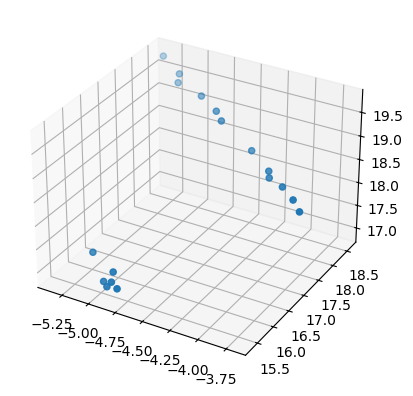

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(d_clust_g2['ln_ROFA'], d_clust_g2['ln_K'], d_clust_g2['ln_L'])
plt.show()

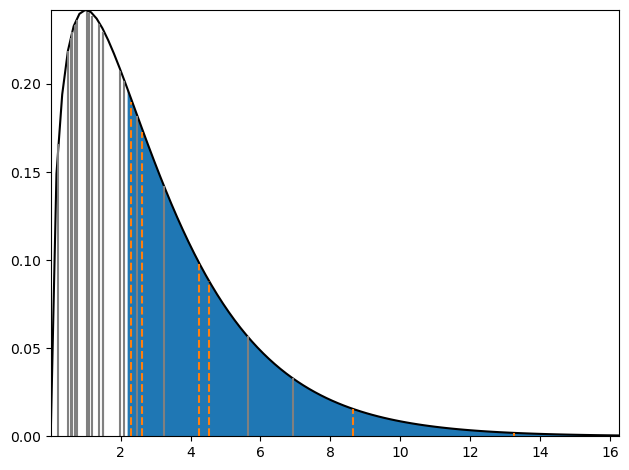

In [ ]:
from scipy.stats import chi2
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize

fig, ax = plt.subplots(1, 1)
df = 3
x = np.linspace(chi2.ppf(1e-10, df), chi2.ppf(0.999, df), 100)
rv = chi2(df)
d_clust_g3.loc[:, ['is_outlier', 'Код раздела']]
ax.plot(x, rv.pdf(x), c='black')

palette = sns.color_palette(n_colors=d_clust_g3['Код раздела'].nunique())
my_cmap = ListedColormap(palette.as_hex())
codes = d_clust_g3['Код раздела'].unique()
industry_colors = {code: (color if code == 'G' else 'grey') for code, color in zip(codes, my_cmap.colors)}
industry_linestyles = {code: ('dashed' if code == 'G' else 'solid') for code in codes}

# for x, ymax in zip(squared_distances, rv.pdf(squared_distances)):
for idx, obs in d_clust_g3.iterrows():
    ax.axvline(obs['m_dist'], ymax=rv.pdf(obs['m_dist'])*4.1,
               linestyle=industry_linestyles[obs['Код раздела']], c=industry_colors[obs['Код раздела']])

x2 = np.linspace(2.2, chi2.ppf(0.999, df), 80)
ax.fill_between(x2, rv.pdf(x2))
plt.margins(x=0, y=0)
fig.tight_layout()
plt.show()

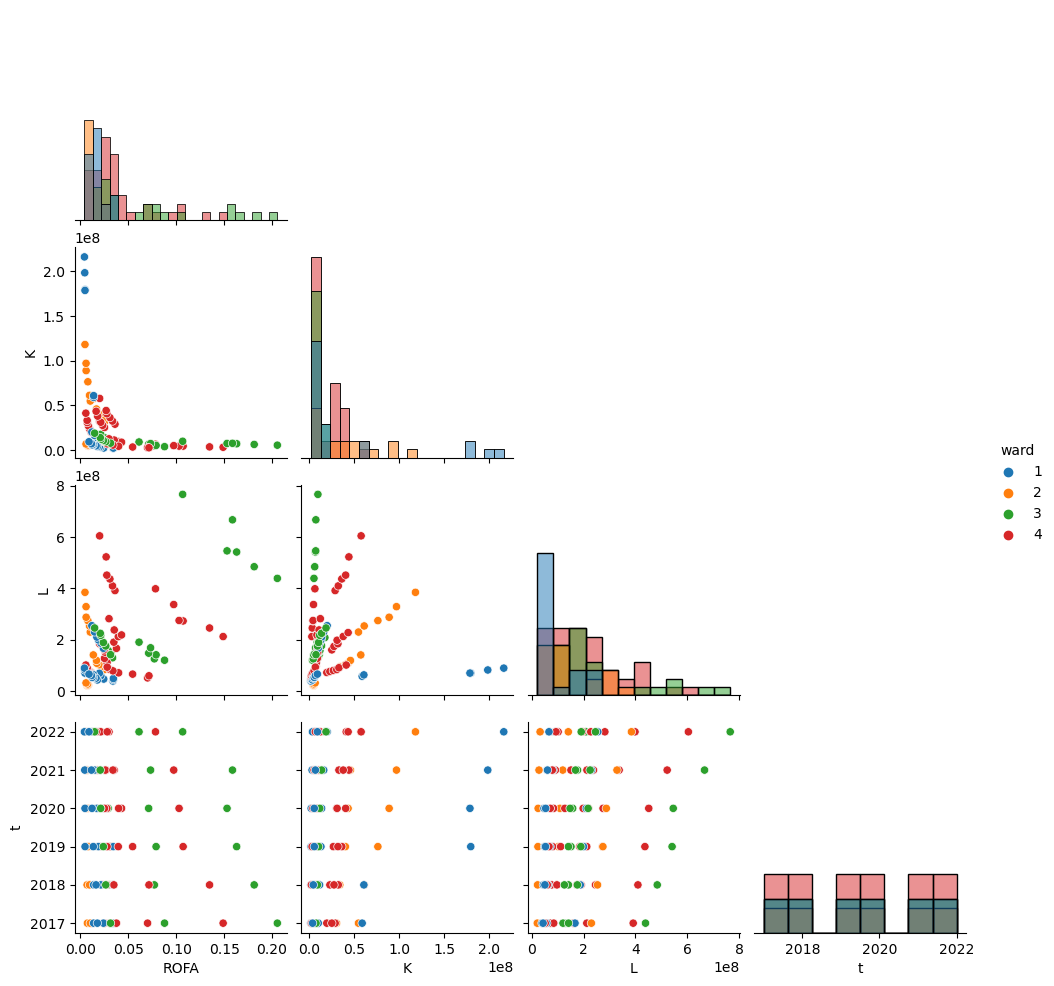

In [ ]:
sns.pairplot(data_clustered_full.loc[:, 'ROFA':'ward'],
            corner=True, hue='ward', diag_kind='hist',
            palette=sns.color_palette(n_colors=cluser_count[0]))
plt.show()

In [ ]:
data_for_ANOVA = pd.merge(cluster_mapping, data_for_regr.loc[:, ["Код раздела", "ROFA"]], 'inner', 'Код раздела')
for linkage_type in linkage_types:
    groups = []
    for group_id in data_for_ANOVA[linkage_type].unique():
        groups.append(data_for_ANOVA["ROFA"][(data_for_ANOVA[linkage_type] == group_id)].to_numpy())
    res = stats.bartlett(*groups)
    print('bartlett', res.pvalue)
    res = stats.kruskal(*groups)
    print('kruskal', res.pvalue)

bartlett 1.6869756877768281e-21
kruskal 4.093038088584397e-10
bartlett 7.788642596485494e-21
kruskal 9.672797115345697e-10
bartlett 8.065545418041749e-15
kruskal 2.1106469870207733e-08
bartlett 4.920846559604251e-14
kruskal 4.191333764938356e-09
